In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

root_path = "/content/gdrive/My Drive/AlgoTrading/Pair_Trading_Reinforcement_Learning"

import os 
os.chdir(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Import Library**

In [0]:
import pandas as pd
import numpy as np
import MAIN.Basics as basics
import MAIN.Reinforcement as RL
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from UTIL import FileIO
from STRATEGY.Cointegration import EGCointegration

**Loading Configuration**

In [0]:
# Read config
config_path  = 'CONFIG/config_train.yml'
config_train = FileIO.read_yaml(config_path)

# Read prices
x = pd.read_csv('STATICS/ETH/ETH-USD.csv')
y = pd.read_csv('STATICS/ETH/ETH-JPY.csv')
x, y = EGCointegration.clean_data(x, y, 'Time', 'Mid')

Data Separation

In [0]:
# Separate training and testing sets
train_pct = 0.75
train_len = round(len(x) * 0.75)
idx_train = list(range(0, train_len))
idx_test  = list(range(train_len, len(x)))
EG_Train = EGCointegration(x.iloc[idx_train, :], y.iloc[idx_train, :], 'Time', 'Mid')
EG_Test  = EGCointegration(x.iloc[idx_test,  :], y.iloc[idx_test,  :], 'Time', 'Mid')

Parameters Initialization

In [0]:
# Create action space
n_hist    = list(np.arange(60, 601, 60))
n_forward = list(np.arange(120, 1201, 120))
trade_th  = list(np.arange(1,  5.1, 1))
stop_loss = list(np.arange(1,  2.1, 0.5))
cl        = list(np.arange(0.05,  0.11, 0.05))
actions   = {'n_hist':    n_hist,
             'n_forward': n_forward,
             'trade_th':  trade_th,
             'stop_loss': stop_loss,
             'cl':        cl}
n_action  = int(np.product([len(actions[key]) for key in actions.keys()]))

# Create state space
transaction_cost = [0.001]
states  = {'transaction_cost': transaction_cost}
n_state = len(states)

In [0]:
# Assign state and action spaces to config
config_train['StateSpaceState'] = states
config_train['ActionSpaceAction'] = actions

In [0]:
# Create and build network
one_hot  = {'one_hot': {'func_name':  'one_hot',
                        'input_arg':  'indices',
                         'layer_para': {'indices': None,
                                        'depth': n_state}}}
output_layer = {'final': {'func_name':  'fully_connected',
                          'input_arg':  'inputs',
                          'layer_para': {'inputs': None,
                                         'num_outputs': n_action,
                                         'biases_initializer': None,
                                         'activation_fn': tf.nn.relu,
                                         'weights_initializer': tf.ones_initializer()}}}

state_in = tf.compat.v1.placeholder(shape=[1], dtype=tf.int32)

Loading Models

In [8]:
N = basics.Network(state_in)
N.build_layers(one_hot)
N.add_layer_duplicates(output_layer, 1)

W0809 12:02:20.862927 140031072876416 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
# Create learning object and perform training
RL_Train = RL.ContextualBandit(N, config_train, EG_Train)

sess = tf.Session()
RL_Train.process(sess, save=False, restore=False)

Counter [Iteration]: 1000 steps processed...
Counter [Iteration]: 2000 steps processed...
Counter [Iteration]: 3000 steps processed...
Counter [Iteration]: 4000 steps processed...
Counter [Iteration]: 5000 steps processed...
Counter [Iteration]: 6000 steps processed...
Counter [Iteration]: 7000 steps processed...
Counter [Iteration]: 8000 steps processed...
Counter [Iteration]: 9000 steps processed...
Counter [Iteration]: 10000 steps processed...
Counter [Iteration]: 11000 steps processed...
Counter [Iteration]: 12000 steps processed...
Counter [Iteration]: 13000 steps processed...
Counter [Iteration]: 14000 steps processed...
Counter [Iteration]: 15000 steps processed...
Counter [Iteration]: 16000 steps processed...
Counter [Iteration]: 17000 steps processed...
Counter [Iteration]: 18000 steps processed...
Counter [Iteration]: 19000 steps processed...
Counter [Iteration]: 20000 steps processed...
Counter [Iteration]: Process completed.
Counter [Epoch]: 1 steps processed...
Counter [It

In [10]:
# Extract training results
action = RL_Train.recorder.record['NETWORK_ACTION']
reward = RL_Train.recorder.record['ENGINE_REWARD']
print(np.mean(reward))

-0.1541933672571058


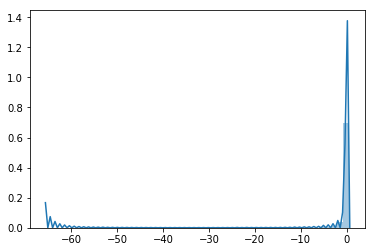

In [11]:
df1 = pd.DataFrame()
df1["action"] = action
df1["reward"] = reward 
mean_reward = df1.groupby('action').mean()
sns.distplot(mean_reward)
plt.show()

In [0]:
[opt_action] = sess.run([RL_Train.output], feed_dict=RL_Train.feed_dict)
opt_action = np.argmax(opt_action)
action_dict = RL_Train.action_space.convert(opt_action, 'index_to_dict')
indices = range(601, len(EG_Test.x) - 1200)

In [0]:
pnl = pd.DataFrame()
pnl['Time'] = EG_Test.timestamp
pnl['Trade_Profit'] = 0
pnl['Cost'] = 0
pnl['N_Trade'] = 0

In [14]:
import warnings
warnings.filterwarnings('ignore')
for i in indices:
    if i % 100 == 0:
        print(i)
    EG_Test.process(index=i, transaction_cost=0.001, **action_dict)
    trade_record = EG_Test.record
    if (trade_record is not None) and (len(trade_record) > 0):
        print('value at {}'.format(i))
        trade_record = pd.DataFrame(trade_record)
        trade_cost   = trade_record.groupby('trade_time')['trade_cost'].sum()
        close_cost   = trade_record.groupby('close_time')['close_cost'].sum()
        profit       = trade_record.groupby('close_time')['profit'].sum()
        open_pos     = trade_record.groupby('trade_time')['long_short'].sum()
        close_pos    = trade_record.groupby('close_time')['long_short'].sum() * -1

        pnl['Cost'].loc[pnl['Time'].isin(trade_cost.index)] += trade_cost.values
        pnl['Cost'].loc[pnl['Time'].isin(close_cost.index)] += close_cost.values
        pnl['Trade_Profit'].loc[pnl['Time'].isin(close_cost.index)] += profit.values
        pnl['N_Trade'].loc[pnl['Time'].isin(trade_cost.index)] += open_pos.values
        pnl['N_Trade'].loc[pnl['Time'].isin(close_cost.index)] += close_pos.values

warnings.filterwarnings(action='once')

value at 601
value at 602
value at 603
value at 604
value at 605
value at 606
value at 607
value at 608
value at 609
value at 610
value at 611
value at 612
value at 613
value at 614
value at 615
value at 616
value at 617
value at 618
value at 619
value at 620
value at 621
value at 622
value at 623
value at 624
value at 625
value at 626
value at 627
value at 628
value at 629
value at 630
value at 631
value at 632
value at 633
value at 634
value at 635
value at 636
value at 637
value at 638
value at 639
value at 640
value at 641
value at 642
value at 643
value at 644
value at 645
value at 646
value at 647
value at 648
value at 649
value at 650
value at 651
value at 652
value at 653
value at 654
value at 655
value at 656
value at 657
value at 658
value at 659
value at 660
value at 661
value at 662
value at 663
value at 664
value at 665
value at 666
value at 667
value at 668
value at 669
value at 670
value at 671
value at 672
value at 673
value at 674
value at 675
value at 676
value at 677

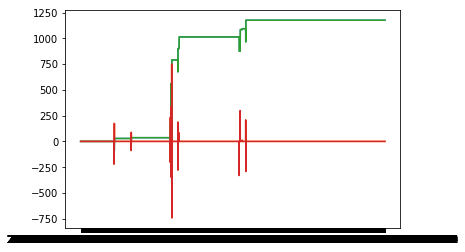

In [15]:
# Plot the testing result
pnl['PnL'] = (pnl['Trade_Profit'] - pnl['Cost']).cumsum()
plt.plot(pnl['PnL'])
plt.plot(pnl['N_Trade'])
plt.plot(pnl['Time'], pnl['PnL'])

plt.plot(pnl['Time'], pnl['N_Trade'])
plt.show()

sess.close()  

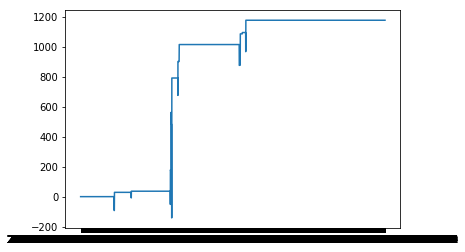

In [25]:
plt.plot(pnl['Time'], pnl['PnL'])

In [21]:
pnl.loc[pnl["Trade_Profit"] > 0, "Trade_Profit"]

1211     166.403127
1212      46.891471
1819      82.208084
3223     326.187264
3225       0.477049
3226       2.358080
3227       0.418192
3228       0.291445
3229       0.371805
3230       0.395921
3231       0.539339
3232       0.465615
3233       0.428858
3234       0.229421
3235       0.289108
3236       0.061122
3237       0.057612
3238       0.060325
3239       0.055849
3241       0.441546
3242       0.685441
3243       1.004483
3244      15.344961
3245     648.766524
3271      10.294909
3272    1237.131022
3494     303.622426
3536       3.237677
3537     134.932973
3538      12.110771
5700       2.464696
5730      14.250751
5731     326.837713
5803      13.602831
5929       0.783408
5930     335.694223
Name: Trade_Profit, dtype: float64

In [22]:
pnl.loc[pnl["Cost"] > 0, "Cost"]

1200     92.341422
1211     72.889970
1212     19.429051
1816     37.239920
1819     37.389010
3219     83.833877
3221      4.103322
3223     96.602134
3224      2.788824
3225      0.399049
3226      1.204830
3227      0.398221
3228      0.398425
3229      0.398667
3230      0.398499
3231      0.398195
3232      0.396900
3233      0.396617
3234      0.396921
3235      0.396565
3236      0.396228
3237      0.396219
3238      0.395954
3239      0.395585
3240      3.561328
3241      0.789468
3242      0.788874
3243      0.784670
3244    138.870255
3245    134.754990
3247     78.735134
3266     81.215150
3270    315.704282
3271      3.344684
3272    312.092349
3493    115.696737
3494     78.015828
3536      0.821514
3537     33.587514
3538      2.861508
5694    138.899886
5700      1.303969
5730      6.856647
5731    125.292797
5803      4.850623
5927     90.927062
5928     36.391272
5929      0.432942
5930    126.789201
Name: Cost, dtype: float64